In [1]:
#  Many unecessary warnings may happen because of the np.exp function used on the
# newral-network parameters to avoid this warning the code below is used to
# ignore warning log

import warnings

# suppress warnings
warnings.filterwarnings('ignore')

In [2]:
import math

import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
np.random.seed(7111996)

In [4]:
# activation functions

def ReLU(X):
  return np.maximum(0, X)

def leakyReLU(X):
  return np.maximum(X * 0.01, X)

def sigmoid(X):
  return 1 / (1 + np.exp(-X))

def tanh(X):
  return np.tanh(X)

def softmax(X):
  exp = np.exp(X - np.max(X, axis=0, keepdims=True))
  return exp / np.sum(exp, axis=0, keepdims=True)

def ReLU_derivative(X):
  return X > 0

def sigmoid_derivative(X):
  return X * (1 - X)

def tanh_derivative(X):
  return 1 - np.power(np.tanh(X), 2)

def leakyReLU_derivative(X):
  bigger_than_0 = X > 0
  less_than_zero = X < 0

  result = np.zeros_like(X)
  result[bigger_than_0] = 1
  result[less_than_zero] = 0.01

  return result

In [5]:
# loss functions

def rmse(y, y_hat):
  squared_err = (y - y_hat) ** 2
  mean = np.sum(squared_err) / squared_err.size
  return np.sqrt(mean)

def mse(y, y_hat):
  squared_err = (y - y_hat) ** 2
  return np.sum(squared_err) / squared_err.size

def mae(y, y_hat):
  abs_err = np.abs(y - y_hat)
  return np.sum(abs_err) / abs_err.size

In [6]:
# parameters functions

def init_weights():
  w1 = np.random.rand(30, 784) * 0.01
  b1 = np.zeros((30, 1))

  w2 = np.random.rand(10, 30) * 0.01
  b2 = np.zeros((10, 1))

  return w1, b1, w2, b2

def forward(X, w1, b1, w2, b2):
  z1 = w1.dot(X) + b1
  a1 = leakyReLU(z1)

  z2 = w2.dot(a1) + b2
  a2 = softmax(z2)

  return z1, a1, z2, a2

def back_propagation(X, y, w2, z1, a1, a2):
  m = X.shape[1]

  y_ohe = one_hot_encode(y, 10)

  dz2 = a2 - y_ohe
  dw2 = 1 / m * dz2.dot(a1.T)
  db2 = 1 / m * np.sum(dz2, axis=1, keepdims=True)

  dz1 = w2.T.dot(dz2) * leakyReLU_derivative(z1)
  dw1 = 1 / m * dz1.dot(X.T)
  db1 = 1 / m * np.sum(dz1, axis=1, keepdims=True)

  return dw1, db1, dw2, db2

def update_weights(w1, b1, w2, b2, dw1, db1, dw2, db2, alpha=0.01):
  w1 = w1 - alpha * dw1
  b1 = b1 - alpha * db1

  w2 = w2 - alpha * dw2
  b2 = b2 - alpha * db2

  return w1, b1, w2, b2

def labels_from_predictions(preds):
  return np.argmax(preds, axis=0)

In [7]:
# metric functions

def acuracy(y, y_hat):
  return np.sum(y == y_hat) / y_hat.size

In [8]:
# data manipulations functions

def one_hot_encode(y, class_num):
  encoded_arr = np.zeros((class_num, y.size))
  encoded_arr[y, np.arange(y.size)] = 1
  return encoded_arr

In [9]:
# alpha decay functions

class ExponentialLearningRateDecay:
  def __init__(self, init_lr=0.1, k=0.1):
    self.lr = init_lr
    self.init_lr = init_lr
    self.k = 0.1

  def __call__(self, alpha, epoch):
    self.lr = self.init_lr * (2.71 ** (-self.k * epoch))
    return self.lr

class StepLearningRateDecay:
  def __init__(self, init_lr=0.1, epochs_drop=10, drop=0.5):
    self.lr = init_lr
    self.init_lr = init_lr
    self.epochs_drop = epochs_drop
    self.drop = drop

  def __call__(self, alpha, epoch):
    self.lr = self.init_lr * self.drop ** math.floor(epoch / self.epochs_drop)
    return self.lr

In [10]:
# training functions

basic_alpha_modifier = lambda x, i: x

def train(x, y, x_val, y_val, alpha, epochs, alpha_modifier=basic_alpha_modifier):
  acc = []
  loss = []
  epoch_alpha = alpha

  w1, b1, w2, b2 = init_weights()
  for epoch in range(epochs):
    epoch_alpha = alpha_modifier(epoch_alpha, epoch)

    z1, a1, z2, a2 = forward(x, w1, b1, w2, b2)
    dw1, db1, dw2, db2 = back_propagation(x, y, w2, z1, a1, a2)
    w1, b1, w2, b2 = update_weights(w1, b1, w2, b2, dw1, db1, dw2, db2, epoch_alpha)

    _, _, _, a3_val = forward(x_val, w1, b1, w2, b2)

    labels = labels_from_predictions(a3_val)
    acc.append(acuracy(y_val, labels))
    loss.append(mae(y_val, labels))

    if epoch % 10 == 0:
      print(f'Epoch: {epoch} | acc: {acc[-1]} | loss: {loss[-1]} | learning rate: {epoch_alpha}')

  return w1, b1, w2, b2, acc, loss

## Importing dataset

In [11]:
mnist = fetch_openml('mnist_784')

In [12]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [13]:
x = mnist.data
y = mnist.target

In [14]:
x.shape

(70000, 784)

In [15]:
X = x.to_numpy()

In [16]:
y.shape

(70000,)

In [17]:
y_ohe = one_hot_encode(y.astype(int), 10)

In [18]:
y_ohe.shape

(10, 70000)

## Implementing network

In [19]:
X_ = X.T / 255.
y_int = y.to_numpy().astype(int)

x_train = X_[:, 10000:]
x_val = X_[:, :5000]
x_test = X_[:, 5000:10000]

y_train = y_int[10000:]
y_val = y_int[:5000]
y_test = y_int[5000:10000]

## Train model with static learning rate

In [23]:
w1, b1, w2, b2, acc, loss = train(x_train, y_train, x_val, y_val, 0.1, 500)

Epoch: 0 | acc: 0.0958 | loss: 4.465 | learning rate: 0.1
Epoch: 10 | acc: 0.0958 | loss: 4.467 | learning rate: 0.1
Epoch: 20 | acc: 0.0958 | loss: 4.4672 | learning rate: 0.1
Epoch: 30 | acc: 0.1004 | loss: 4.4738 | learning rate: 0.1
Epoch: 40 | acc: 0.1594 | loss: 4.3842 | learning rate: 0.1
Epoch: 50 | acc: 0.206 | loss: 4.1486 | learning rate: 0.1
Epoch: 60 | acc: 0.2586 | loss: 3.6664 | learning rate: 0.1
Epoch: 70 | acc: 0.3198 | loss: 3.1232 | learning rate: 0.1
Epoch: 80 | acc: 0.4168 | loss: 2.4486 | learning rate: 0.1
Epoch: 90 | acc: 0.529 | loss: 1.8266 | learning rate: 0.1
Epoch: 100 | acc: 0.5916 | loss: 1.5 | learning rate: 0.1
Epoch: 110 | acc: 0.6228 | loss: 1.3436 | learning rate: 0.1
Epoch: 120 | acc: 0.6544 | loss: 1.2284 | learning rate: 0.1
Epoch: 130 | acc: 0.6928 | loss: 1.0922 | learning rate: 0.1
Epoch: 140 | acc: 0.727 | loss: 0.9838 | learning rate: 0.1
Epoch: 150 | acc: 0.7556 | loss: 0.8754 | learning rate: 0.1
Epoch: 160 | acc: 0.773 | loss: 0.8224 | le

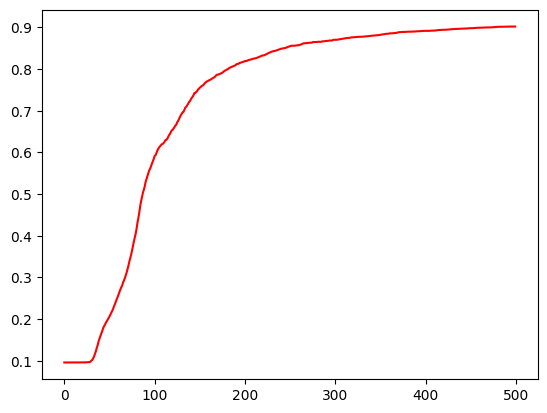

In [25]:
plt.plot(range(0, 500), acc, 'r')
plt.show()

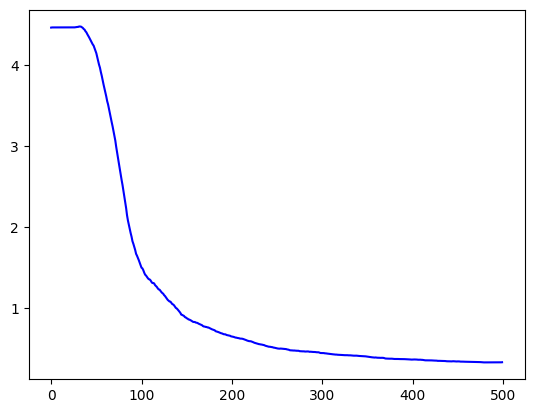

In [26]:
plt.plot(range(0, 500), loss, 'b')
plt.show()

In [27]:
_, _, _, a2_test = forward(x_test, w1, b1, w2, b2)

labels = labels_from_predictions(a2_test)
print(acuracy(y_test, labels))
print(mae(y_test, labels))

0.8932
0.3966


## Testing train with learning rate decay

In [32]:
decay = StepLearningRateDecay(drop=0.99, epochs_drop=50)

In [33]:
w1_decay, b1_decay, w2_decay, b2_decay, acc_decay, loss_decay = train(x_train, y_train, x_val, y_val, 0.1, 500, alpha_modifier=decay)

Epoch: 0 | acc: 0.0958 | loss: 4.467 | learning rate: 0.1
Epoch: 10 | acc: 0.0958 | loss: 4.467 | learning rate: 0.1
Epoch: 20 | acc: 0.0958 | loss: 4.4672 | learning rate: 0.1
Epoch: 30 | acc: 0.1022 | loss: 4.4676 | learning rate: 0.1
Epoch: 40 | acc: 0.1658 | loss: 4.3592 | learning rate: 0.1
Epoch: 50 | acc: 0.2088 | loss: 4.1194 | learning rate: 0.099
Epoch: 60 | acc: 0.245 | loss: 3.6858 | learning rate: 0.099
Epoch: 70 | acc: 0.2916 | loss: 3.211 | learning rate: 0.099
Epoch: 80 | acc: 0.3768 | loss: 2.576 | learning rate: 0.099
Epoch: 90 | acc: 0.4956 | loss: 1.9402 | learning rate: 0.099
Epoch: 100 | acc: 0.5838 | loss: 1.5418 | learning rate: 0.09801
Epoch: 110 | acc: 0.6278 | loss: 1.3494 | learning rate: 0.09801
Epoch: 120 | acc: 0.6596 | loss: 1.21 | learning rate: 0.09801
Epoch: 130 | acc: 0.6898 | loss: 1.0934 | learning rate: 0.09801
Epoch: 140 | acc: 0.7186 | loss: 1.008 | learning rate: 0.09801
Epoch: 150 | acc: 0.7458 | loss: 0.911 | learning rate: 0.0970299
Epoch: 1

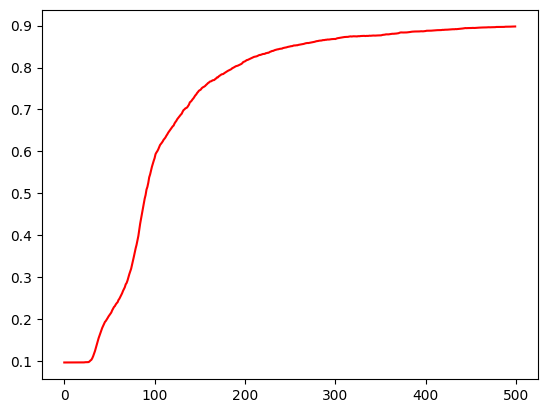

In [34]:
plt.plot(range(0, 500), acc_decay, 'r')
plt.show()

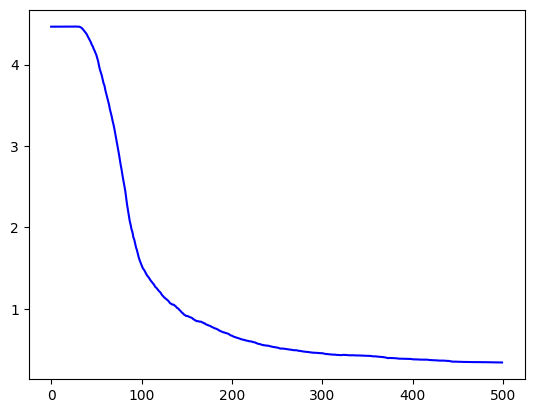

In [35]:
plt.plot(range(0, 500), loss_decay, 'b')
plt.show()

In [36]:
_, _, _, a2_test = forward(x_test, w1_decay, b1_decay, w2_decay, b2_decay)

labels = labels_from_predictions(a2_test)
print(acuracy(y_test, labels))
print(mae(y_test, labels))

0.8924
0.3888


## Showing the images and predictions of test set

Example 1:

In [37]:
img = x_test.T[0].reshape((784, 1))

_, _, _, a2_test = forward(img, w1, b1, w2, b2)

labels_from_predictions(a2_test)

array([7])

In [116]:
y_test[0]

7

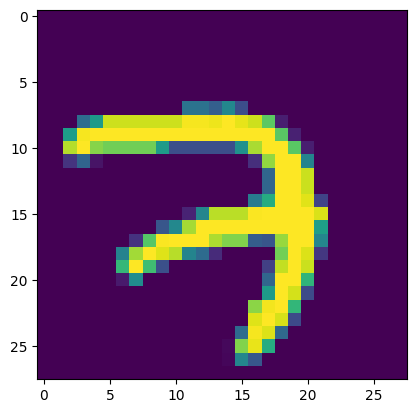

In [38]:
import matplotlib.image as mpimg

plt.figure()
imgplot = plt.imshow(x_test.T[0].reshape((28, 28, 1)))
plt.show()

Example 2:

In [39]:
img = x_test.T[2].reshape((784, 1))

_, _, _, a2_test = forward(img, w1, b1, w2, b2)

labels_from_predictions(a2_test)

array([9])

In [41]:
y_test[2]

4

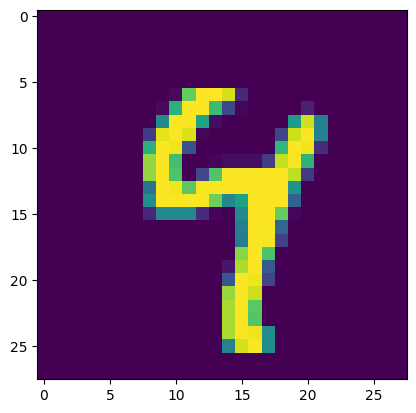

In [40]:
import matplotlib.image as mpimg

plt.figure()
imgplot = plt.imshow(x_test.T[2].reshape((28, 28, 1)))
plt.show()

Example 3:

In [42]:
img = x_test.T[3].reshape((784, 1))

_, _, _, a2_test = forward(img, w1, b1, w2, b2)

labels_from_predictions(a2_test)

array([6])

In [43]:
y_test[3]

6

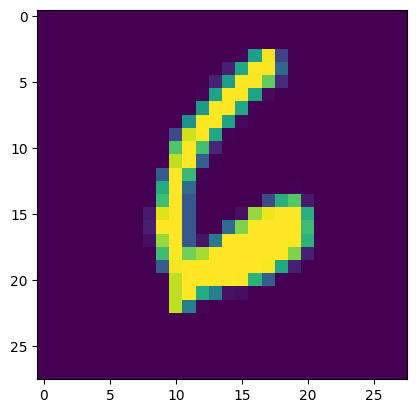

In [44]:
import matplotlib.image as mpimg

plt.figure()
imgplot = plt.imshow(x_test.T[3].reshape((28, 28, 1)))
plt.show()